In [1]:
#Load libraries 

import pandas as pd
import sspa
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy

In [4]:
#For metabolomic:
df = pd.read_csv('../Data/Su_COVID_metabolomics_processed_commoncases.csv', index_col=0)
analytes_in_df = df.columns[:-2]
reactome_pathways = sspa.process_gmt("../Data/Reactome_Homo_sapiens_pathways_compounds_R84.gmt")  #2294 Reactome pathways


In [5]:
#For proteomic:
df = pd.read_csv('../Data/Su_COVID_proteomics_processed_commoncases.csv', index_col=0)
analytes_in_df = df.columns[:-2]
reactome_pathways = sspa.process_reactome('Homo sapiens', infile = '../Data/UniProt2Reactome_All_Levels_ver84.txt', download_latest = False, filepath = None) #2596 Reactome pathways
reactome_pathways

,Pathway_name,0,1,2,3,4,5,6,7,8,...,2588,2589,2590,2591,2592,2593,2594,2595,2596,2597
R-HSA-1059683,Interleukin-6 signaling,P08887-2,O60674,P22681,P42224-1,Q06124,P40189-1,P29597,P42224,O14543,...,None,None,None,None,None,None,None,None,None,None
R-HSA-109581,Apoptosis,O00429,P28065,O00231,P25054,Q13813,Q9BXH1,P50591,Q96FJ2,P09429,...,None,None,None,None,None,None,None,None,None,None
R-HSA-109582,Hemostasis,P29622,P01566,Q9NZN3,P02768,P01615,O14763,Q5UE93,Q96Q89,P01562,...,None,None,None,None,None,None,None,None,None,None
R-HSA-109606,Intrinsic Pathway for Apoptosis,O15350,Q9BXH1,Q9NQS1,P57764,Q04917,Q96FJ2,P45983,P31947,P63098,...,None,None,None,None,None,None,None,None,None,None
R-HSA-109703,PKB-mediated events,Q13370,P31751,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R-HSA-983695,Antigen activates B Cell Receptor (BCR) leadin...,Q96B97,O43865,P01764,P01615,P01717,P01593,P0CF74,P01705,Q6PIL0,...,None,None,None,None,None,None,None,None,None,None
R-HSA-983705,Signaling by the B Cell Receptor (BCR),Q96B97,O43865,P28065,O00231,P01764,Q08209,P01615,P01717,P01593,...,None,None,None,None,None,None,None,None,None,None
R-HSA-983712,Ion channel transport,Q9BYP7,Q13733,Q8TD43,Q9Y572,Q99437,Q8WZ55,Q9H0M0,P05026,Q9BX84,...,None,None,None,None,None,None,None,None,None,None
R-HSA-991365,Activation of GABAB receptors,Q08828,O60503,P59768,P61952,P51828,Q9UBS5,P04899,P62873,O60266,...,None,None,None,None,None,None,None,None,None,None


In [11]:
#https://stackoverflow.com/questions/26977076/pandas-unique-values-multiple-columns
#"ravel() is an array method that returns a view (if possible) of a multidimensional array. The argument 'K' tells the method to flatten the array in the order the elements are stored in the memory"
analytes_in_reactome = pd.unique(reactome_pathways.iloc[:,1:].values.ravel('K'))

In [12]:
#Number of analytes in the dataset that map to a Reactome pathway
analytes_mapping_reactome = list(set(analytes_in_reactome) & set(analytes_in_df)) #set removes duplicates

In [5]:
#Can make a Venn diagram with these results (not a bar graph because of the high numbers of total metabolites in reactome, not a contingency table because no double negative)
print(len(analytes_in_df)) #333 metabolites, 454 proteins
print(len(analytes_in_reactome)) #2393 unique Reactome metabolites, 11596 unique Reactome proteins
print(len(analytes_mapping_reactome)) #78 metabolites in the dataset that map to a reactome pathway, 354 proteins 

333
2393
78


In [13]:
print(( len(analytes_mapping_reactome) / len(analytes_in_df) ) *100) # 23.42% of metabolites in the dataset map to a Reactome pathway, 77.97% of proteins

77.97356828193833


Get average of the length of Reactome pathways, and then calculate percentage of analytes that map to each Reactome pathway:

In [14]:
pathway_len = []  #length of each Reactome pathway
number_coverage = [] #number of analytes in the dataset for a Reactome pathway if 2 or more analytes from data present
percentage_coverage = [] #pathway coverage with the dataset for a Reactome pathway if 2 or more analytes from data present

for index in range(len(reactome_pathways)):

    #Obtain list of analytes per pathways
    list1 = reactome_pathways.iloc[index,1:]
    #list2 = [i for i in list1 if i != ''] #metabolomic
    list2 = [i for i in list1 if i != None]  #proteomic
    
    #Get number of analytes present in dataset present in each pathways
    number_mapping = len(list(set(list2) & set(analytes_in_df)))
    #If the number is 2 or over (min number to be in a pathway using sspa kPCA) append to list
    if number_mapping >= 2:
        number_coverage.append(number_mapping)
        #Get the fraction of metabolites mapping to a pathway so you can make a plot
        percentage_coverage.append((number_mapping/len(list2)) * 100)

    #Get length of pathway 
    pathway_len.append(len(list2))
    

print("Average length of Reactome pathway: ", sum(pathway_len) / len(pathway_len), "analytes")
print("Number of pathways that will be detected by sspa: ", len(percentage_coverage))
print("Average analytes present in pathway: ", sum(number_coverage) / len(number_coverage), "analytes")
print("Average pathway coverage: ", sum(percentage_coverage) / len(percentage_coverage), "%")

Average length of Reactome pathway:  49.74306625577812 analytes
Number of pathways that will be detected by sspa:  603
Average analytes present in pathway:  6.200663349917082 analytes
Average pathway coverage:  9.070738437503643 %


Note: You remove the root pathways so the number of pathways are not the same here

Metabolomic: <br> 
Average length of Reactome pathway:  13.640366172624237 analytes <br>
Number of pathways that will be detected by sspa:  160 <br>
Average analytes present in pathway:  5.125 analytes <br>
Average pathway coverage:  12.772397118617086 % <br>

Proteomic: <br>
Average length of Reactome pathway:  49.74306625577812 analytes <br>
Number of pathways that will be detected by sspa:  603 <br>
Average analytes present in pathway:  6.200663349917082 analytes <br>
Average pathway coverage:  9.070738437503643 % <br>

In order to plot the data for both omics, you would need to run the metabolomic code first then save the data as a another variable, then repeat for proteomic data.

In [9]:
metabolomic_number_coverage #= number_coverage

In [15]:
proteomic_number_coverage# = number_coverage

In [16]:
meta_df = pd.DataFrame()
meta_df['val']  = np.log10(metabolomic_number_coverage)
meta_df['Type'] = "Metabolomic"

pro_df = pd.DataFrame()
pro_df['val']  = np.log10(proteomic_number_coverage)
pro_df['Type'] = "Proteomic"

number_df = pd.concat([meta_df, pro_df], axis=0)
number_df

,val,Type
0,0.301030,Metabolomic
1,0.903090,Metabolomic
2,0.477121,Metabolomic
3,1.000000,Metabolomic
4,1.000000,Metabolomic
...,...,...
598,0.602060,Proteomic
599,0.954243,Proteomic
600,0.301030,Proteomic
601,0.477121,Proteomic


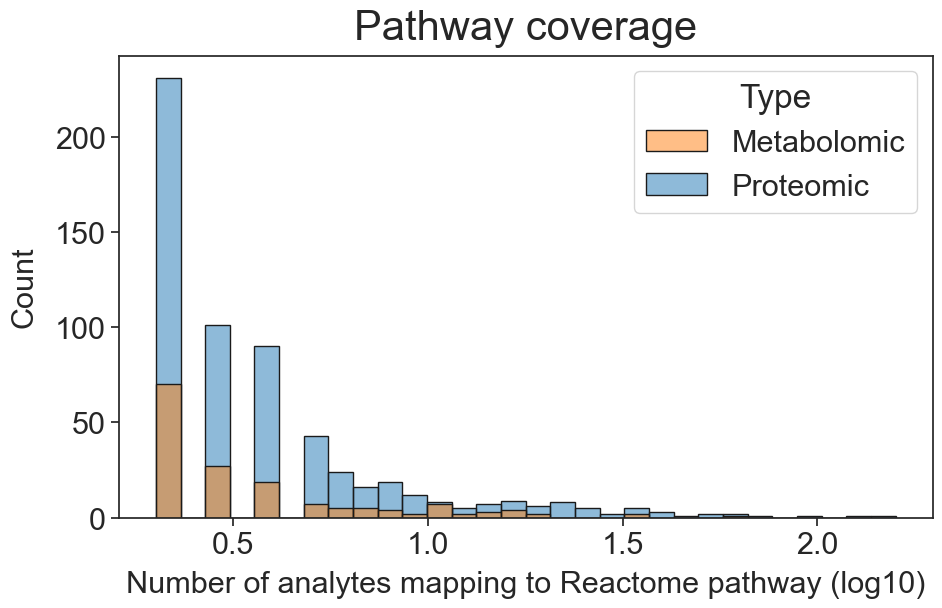

In [24]:
sns.set(font_scale = 2)
sns.set_style("ticks") # same as "white" but with ticks
plt.figure(figsize=(10.5,6))

#Change because I want metabolomics to be orange, proteomics to be blue
palette = ['tab:orange', 'tab:blue']

sns.histplot(number_df, x="val", hue="Type",palette=palette,edgecolor="k", bins = 30) #, bins = 30,color='#79C99E',edgecolor="k") 

plt.title('Pathway coverage',fontsize=30,pad=12)
plt.xlabel('Number of analytes mapping to Reactome pathway (log10)',fontsize=22,labelpad=8)
plt.ylabel('Count',fontsize=22, labelpad=12) ;


#plt.savefig( '../Figures/number_pathway_coverage.png' , dpi=300,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

In [9]:
metabolomic_percentage_coverage # = percentage_coverage

In [16]:
proteomic_percentage_coverage #= percentage_coverage

In [17]:
meta_df = pd.DataFrame()
meta_df['val']  = metabolomic_percentage_coverage
meta_df['Type'] = "Metabolomic"

pro_df = pd.DataFrame()
pro_df['val']  = proteomic_percentage_coverage
pro_df['Type'] = "Proteomic"

number_df = pd.concat([meta_df, pro_df], axis=0)
number_df

,val,Type
0,20.000000,Metabolomic
1,16.326531,Metabolomic
2,8.823529,Metabolomic
3,12.345679,Metabolomic
4,12.345679,Metabolomic
...,...,...
598,1.294498,Proteomic
599,2.331606,Proteomic
600,1.250000,Proteomic
601,3.157895,Proteomic


100.0


Text(0, 0.5, 'Count')

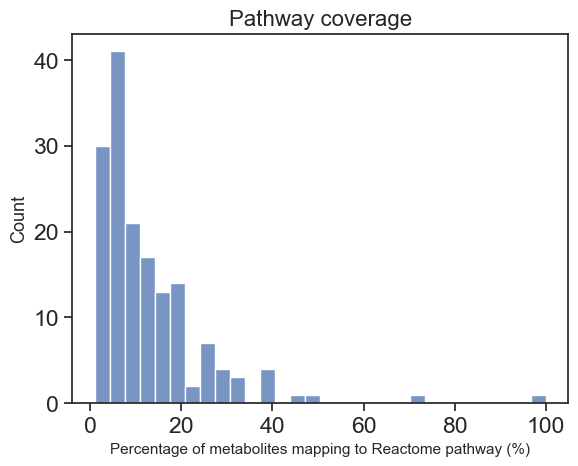

In [81]:
print(max(metabolomic_percentage_coverage))

sns.histplot(metabolomic_percentage_coverage,bins = 30) 
plt.title('Pathway coverage',fontsize=16)
plt.xlabel('Percentage of metabolites mapping to Reactome pathway (%)',fontsize=11)
plt.ylabel('Count',fontsize=13)

66.66666666666666


Text(0, 0.5, 'Count')

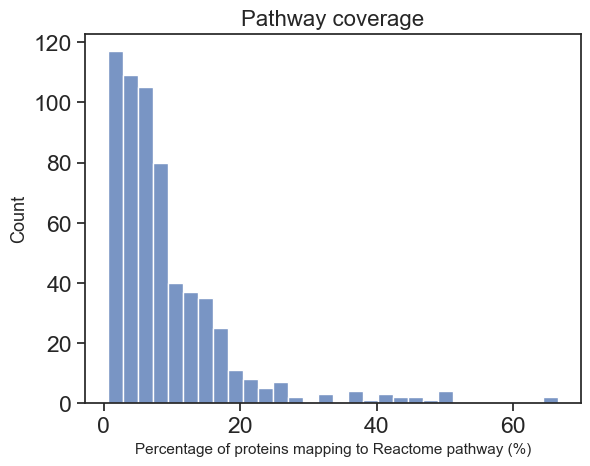

In [85]:
print(max(proteomic_percentage_coverage))

sns.histplot(proteomic_percentage_coverage,bins = 30) 
plt.title('Pathway coverage',fontsize=16)
plt.xlabel('Percentage of proteins mapping to Reactome pathway (%)',fontsize=11)
plt.ylabel('Count',fontsize=13)

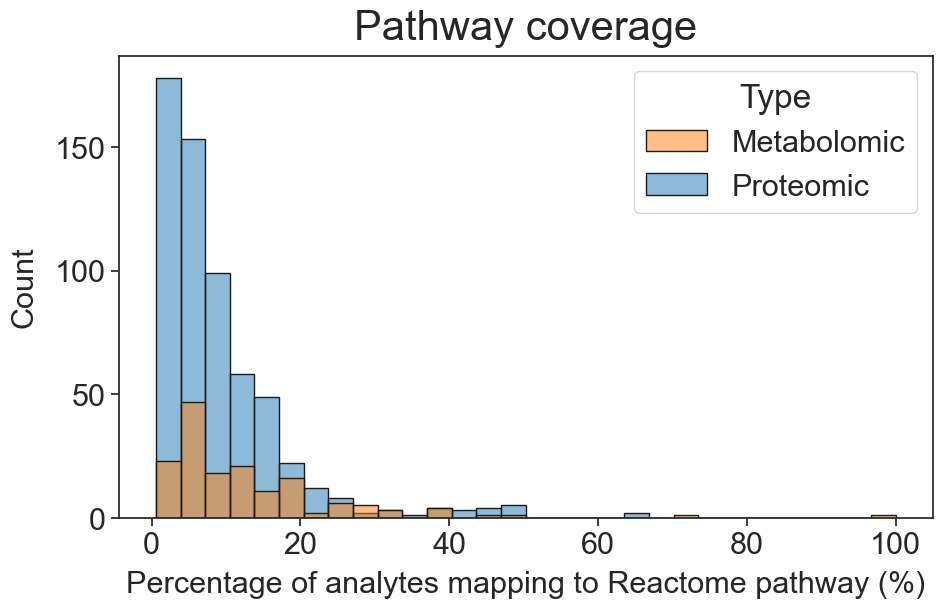

In [19]:
sns.set(font_scale = 2)
sns.set_style("ticks") # same as "white" but with ticks
plt.figure(figsize=(10.5,6))

#Change because I want metabolomics to be orange, proteomics to be blue
palette = ['tab:orange', 'tab:blue']

sns.histplot(number_df, x="val", hue="Type",palette=palette,edgecolor="k",bins = 30) #, bins = 30,color='#79C99E',edgecolor="k") 

plt.title('Pathway coverage',fontsize=30,pad=12)
plt.xlabel('Percentage of analytes mapping to Reactome pathway (%)',fontsize=22,labelpad=8)
plt.ylabel('Count',fontsize=22, labelpad=12) ;

#plt.savefig( '../Figures/percent_pathway_coverage.png' , dpi=300,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')

Calculating pathway scores and getting the pathways in common between both:

In [272]:
meta_df = pd.read_csv('Data/Su_COVID_metabolomics_processed_commoncases.csv', index_col=0)
metabolomic_reactome_pathways = sspa.process_gmt("Data/Reactome_Homo_sapiens_pathways_compounds_R84.gmt")
metabolomic_kpca_scores = sspa.sspa_kpca(meta_df.iloc[:,:-2], metabolomic_reactome_pathways)

analytes_in_meta_df = meta_df.columns[:-2]

In [313]:
pro_df = pd.read_csv('Data/Su_COVID_proteomics_processed_commoncases.csv', index_col=0)
proteomic_reactome_pathways = sspa.process_reactome('Homo sapiens', infile = 'Data/UniProt2Reactome_All_Levels.txt', download_latest = False, filepath = None)
proteomic_kpca_scores = sspa.sspa_kpca(pro_df.iloc[:,:-2], proteomic_reactome_pathways)

analytes_in_pro_df = pro_df.columns[:-2]

In [274]:
#Get common pathways
 
intersection = list(set(metabolomic_kpca_scores.columns.tolist()) & set(proteomic_kpca_scores.columns.tolist())) #set removes duplicates

#Remove root pathways
root_path = pd.read_excel('Data/Root_pathways.xlsx', header=None)
root_pathway_dict = {root_path[0][i]:root_path[1][i] for i in range(0,len(root_path))}
root_pathway_names = list(root_pathway_dict.keys())

common_pathways = [i for i in intersection if i not in root_pathway_names]

In [275]:
common_pathway_metabolite_df = metabolomic_reactome_pathways.loc[metabolomic_reactome_pathways.index.isin(common_pathways), : ]
common_pathway_protein_df = proteomic_reactome_pathways.loc[proteomic_reactome_pathways.index.isin(common_pathways), : ]

In [314]:
#For metabolomic data:

pathway_len = []  #length of each Reactome pathway
number_coverage = [] #number of analytes in the dataset for a Reactome pathway if 2 or more analytes from data present
percentage_coverage = [] #pathway coverage with the dataset for a Reactome pathway if 2 or more analytes from data present

for index in range(len(common_pathway_metabolite_df)):

    #Obtain list of analytes per pathways
    meta_list = common_pathway_metabolite_df.iloc[index,1:]
    meta_list2 = [i for i in meta_list if i != ''] #metabolomic

    #Get number of analytes present in dataset present in each pathways
    number_mapping = len(list(set(meta_list2) & set(analytes_in_meta_df)))
    #If the number is 2 or over (min number to be in a pathway using sspa kPCA) append to list
    if number_mapping >= 2:
        number_coverage.append(number_mapping)
        #Get the fraction of metabolites mapping to a pathway so you can make a plot
        percentage_coverage.append((number_mapping/len(meta_list2)) * 100)

    #Get length of pathway 
    pathway_len.append(len(meta_list2))

In [315]:
#For proteomic data:

pathway_len = []  #length of each Reactome pathway
number_coverage = [] #number of analytes in the dataset for a Reactome pathway if 2 or more analytes from data present
percentage_coverage = [] #pathway coverage with the dataset for a Reactome pathway if 2 or more analytes from data present

for index in range(len(common_pathway_protein_df)):

    #Obtain list of analytes per pathways
    pro_list = common_pathway_protein_df.iloc[index,1:]
    pro_list2 = [i for i in pro_list if i != None]  #proteomic

    #Get number of analytes present in dataset present in each pathways
    number_mapping = len(list(set(pro_list2) & set(analytes_in_pro_df)))
    #If the number is 2 or over (min number to be in a pathway using sspa kPCA) append to list
    if number_mapping >= 2:
        number_coverage.append(number_mapping)
        #Get the fraction of metabolites mapping to a pathway so you can make a plot
        percentage_coverage.append((number_mapping/len(pro_list2)) * 100)

    #Get length of pathway 
    pathway_len.append(len(pro_list2))


In [316]:
number_coverage

[3,
 2,
 2,
 4,
 7,
 3,
 57,
 2,
 3,
 7,
 9,
 5,
 3,
 2,
 5,
 22,
 2,
 2,
 7,
 34,
 25,
 5,
 28,
 5,
 7,
 17,
 3,
 30,
 17,
 36,
 14,
 2,
 38,
 3,
 2,
 9,
 10,
 2,
 2,
 4,
 2,
 4,
 4,
 2,
 2,
 8,
 3]

In [278]:
full_df =  pd.DataFrame(index=common_pathway_metabolite_df.index)
#full_df

In [279]:
full_df['Metabolite number'] = number_coverage
full_df['Metabolite percent'] = percentage_coverage

In [317]:
full_df['Protein number'] = number_coverage
full_df['Protein percent'] = percentage_coverage

In [318]:
full_df.sort_values(by=['Metabolite number'],ascending=False)[:5]

,Metabolite number,Metabolite percent,Protein number,Protein percent
Pathway_ID,,,,
R-HSA-556833,18,2.682563,17,2.260638
R-HSA-211859,16,4.790419,9,4.035874
R-HSA-71291,16,5.333333,9,2.393617
R-HSA-372790,12,4.979253,34,4.768583
R-HSA-388396,12,7.547170,28,4.388715


In [125]:
full_df.sort_values(by=['Metabolite percent'],ascending=False)[:5]

,Metabolite number,Metabolite percent,Protein number,Protein percent
Pathway_ID,,,,
R-HSA-381340,2,18.181818,5,5.952381
R-HSA-8956321,8,17.391304,2,8.695652
R-HSA-2151201,2,13.333333,2,3.508772
R-HSA-1592230,2,12.500000,3,3.125000
R-HSA-5683826,2,12.500000,2,6.666667


In [129]:
full_df.sort_values(by=['Protein number'],ascending=False)[:5]

,Metabolite number,Metabolite percent,Protein number,Protein percent
Pathway_ID,,,,
R-HSA-168249,2,1.492537,57,4.765886
R-HSA-597592,4,2.150538,38,2.659202
R-HSA-5663205,2,0.975610,36,2.816901
R-HSA-372790,12,4.979253,34,4.768583
R-HSA-500792,11,5.116279,30,6.382979


In [127]:
full_df.sort_values(by=['Protein percent'],ascending=False)[:5]

,Metabolite number,Metabolite percent,Protein number,Protein percent
Pathway_ID,,,,
R-HSA-2408508,2,6.060606,2,25.000000
R-HSA-8956319,9,8.411215,4,10.526316
R-HSA-8956321,8,17.391304,2,8.695652
R-HSA-2980736,4,6.896552,7,7.954545
R-HSA-373076,9,5.732484,25,7.507508


In [319]:
#R-HSA-556833 = Metabolism of lipids (common pathway with the most metabolites present, similar number and percentage of coverage with proteomic)
#Comparing with R-HSA-196854 = Metabolism of vitamins and cofactors (2 out of 7 metabolites in common)

list1 = common_pathway_metabolite_df.loc["R-HSA-556833"][1:]
list2 = [i for i in list1 if i != ''] #metabolomic

metabolites_in_pathway = list(set(list2) & set(analytes_in_df)) #set removes duplicates

In [320]:
#Comparing with R-HSA-196854 = Metabolism of vitamins and cofactors (0 out of 7 proteins in common)

list1 = common_pathway_protein_df.loc["R-HSA-556833"][1:]
list2 = [i for i in list1 if i != None]  #proteomic
proteins_in_pathway1 = list(set(list2) & set(analytes_in_df)) #set removes duplicates

In [321]:
metabolites_in_pathway

['16566',
 '2700',
 '17553',
 '18132',
 '15354',
 '46195',
 '28834',
 '29746',
 '17351',
 '30769',
 '16962',
 '15344',
 '17754',
 '16827',
 '15756',
 '17066',
 '16525',
 '17268']

In [322]:
proteins_in_pathway

['P16278',
 'P12104',
 'Q9NPH0',
 'P01229',
 'O15357',
 'Q03426',
 'O60760',
 'P51161',
 'P28845',
 'O60240',
 'P09960',
 'Q15165',
 'Q16698',
 'Q8NBJ7',
 'P27540',
 'Q0Z7S8',
 'Q6UWV6']

In [323]:
df

,1372,16610,72665,27823,30915,37373,16831,545959,17050,16359,...,133693,133694,28036,28238,76341,89312,17861,89188,WHO_status,Group
sample_id,,,,,,,,,,,,,,,,,,,,,
INCOV001,-0.342522,-0.830841,-0.703451,-0.451278,0.153207,-0.443252,-0.228725,0.501998,-0.861886,-0.344155,...,-0.465505,0.055753,-0.225622,0.400398,0.163210,1.579262,-0.162221,-0.603790,3-4,COVID19
INCOV002,-0.125585,-1.002246,0.399273,-0.828341,-0.980576,0.373921,-1.076979,-0.131876,-0.869093,-0.467326,...,0.509336,0.627269,0.321718,-0.158514,0.001469,-1.051485,1.299330,0.578560,5-7,COVID19
INCOV003,-0.859326,-0.409159,3.573100,-0.546783,-0.993647,1.547649,0.370131,-0.020399,-0.703786,-0.015627,...,2.056610,1.717149,-0.297723,-1.276891,-0.658288,2.141594,-1.091183,0.447197,5-7,COVID19
INCOV004,-0.562999,-1.560249,-1.269383,-1.437919,0.108734,-0.192066,0.161591,-0.586759,-1.457246,-0.500612,...,0.793065,-0.033125,-0.366082,-0.642671,1.724436,2.074193,-1.021184,-0.410849,3-4,COVID19
INCOV005,-0.741957,0.387909,-0.711036,-0.711515,0.670720,0.610591,-0.322241,-0.793451,-1.230681,-0.246493,...,-0.184967,-0.469553,-0.293869,0.558366,-0.390308,-0.455737,-0.535223,-0.847727,3-4,COVID19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
INCOV135,-2.075777,-0.485936,-0.671225,0.069483,0.042579,0.357250,-0.505272,-0.378441,-0.444915,-0.368108,...,-0.516557,-0.392716,-0.328170,1.013774,-0.391566,-0.407585,1.041224,-0.866190,1-2,COVID19
INCOV136,-0.174602,1.167644,0.055499,0.113342,-0.663851,0.799367,0.004697,0.748894,1.328753,0.391221,...,-0.741578,-0.730981,-0.380517,-1.251641,0.389163,-0.603048,0.941619,-0.511694,3-4,COVID19
INCOV137,0.274900,-0.014841,-0.928512,0.885263,-1.591862,0.230250,0.057818,-0.775962,-0.179700,-0.534786,...,-1.306132,-1.246428,1.763824,1.258387,0.448359,-0.508931,0.268474,-0.997206,5-7,COVID19


Unsure about multiple testing correction since removing some analytes will lead to less pathways than usual

In [325]:

df = pd.read_csv('Data/Su_COVID_metabolomics_processed_commoncases.csv', index_col=0)
reactome_pathways = sspa.process_gmt("Data/Reactome_Homo_sapiens_pathways_compounds_R84.gmt")
random.shuffle(metabolites_in_pathway)
metabolites_in_pathway_subset = metabolites_in_pathway[:-4]
print(metabolites_in_pathway_subset)
df_subset = df.drop(columns = list(set(metabolites_in_pathway_subset) & set(df.columns)))

kpca_scores = sspa.sspa_kpca(df_subset, reactome_pathways)   
kpca_scores = kpca_scores.drop(columns = list(set(root_pathway_names) & set(kpca_scores.columns))) #using Sara's code to drop root pathways

spearman_results = scipy.stats.spearmanr(kpca_scores.loc[:,["R-HSA-556833","R-HSA-196854"]])
squared_spearman_coef = np.square(spearman_results[1]) #correlation coefficients (spearman_results[1] gives the p-values)

squared_spearman_coef

['17268', '28834', '18132', '17066', '16525', '15344', '15756', '46195', '16962', '17754', '17553', '15354', '29746', '16566']


1.2795477219714652e-20